In [1]:
from google.colab import drive
import sys

#Mount your Google drive to the VM
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/ECE4179_COLAB/Project2")

#set a root path variable to use
ROOT = "/content/gdrive/My Drive/ECE4179_COLAB/Project2"

#Follow link and give permission, copy code and paste in text box
#You only have to do this once per session

Mounted at /content/gdrive


In [2]:
"""
Pytorch implementation of CapsNet in paper Dynamic Routing Between Capsules.
The current version maybe only works for TensorFlow backend. Actually it will be straightforward to re-write to TF code.
Adopting to other backends should be easy, but I have not tested this.

Usage:
       Launch `python CapsNet.py -h` for usage help

Result:
    Validation accuracy > 99.6% after 50 epochs.
    Speed: About 73s/epoch on a single GTX1070 GPU card and 43s/epoch on a GTX1080Ti GPU.

Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Pytorch`
"""

import torch
from torch import nn
from torch.optim import Adam, lr_scheduler
from torch.autograd import Variable
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import numpy as np
# # show_reconstruction
# import matplotlib.pyplot as plt
# from PIL import Image
# import numpy as np

# # train
# from time import time
# import csv

# main
import argparse
import os

# # mnist
# from torch.utils.data import random_split

from torchsummary import summary

from capsulenet import CapsuleNet, CapsuleNet56, train, test, show_reconstruction, load_mnist
from utils import combine_images, plot_log
from convnet import ConvNet, ConvNet56, train_cnn, evaluate_cnn

In [3]:
#Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# MNIST 28x28, 60000 images for training, 10000 images for testing

Namespace(batch_size=100, data_dir='/content/gdrive/My Drive/ECE4179_COLAB/Project2/data_0522', epochs=50, lam_recon=0.392, lr=0.001, lr_decay=0.9, routings=3, save_dir='/content/gdrive/My Drive/ECE4179_COLAB/Project2/result_0522', shift_pixels=2, testing=True, weights='/content/gdrive/My Drive/ECE4179_COLAB/Project2/result_0522/trained_model28.pkl')
CapsuleNet(
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (primarycaps): PrimaryCapsule(
    (conv2d): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  )
  (digitcaps): DenseCapsule()
  (decoder): Sequential(
    (0): Linear(in_features=160, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
  (relu): ReLU()
)
test acc = 0.9962, test loss = 0.00860

Reconstructed images are saved to /content/gdrive/My Drive/ECE4179_COLAB/Project2/result_0

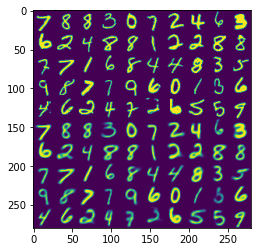

In [4]:
if __name__ == "__main__":

    
    # setting the hyper parameters
    parser = argparse.ArgumentParser(description="Capsule Network on MNIST 28x28.")
    
    parser.add_argument('--epochs', default=50, type=int)
    parser.add_argument('--batch_size', default=100, type=int)
    parser.add_argument('--lr', default=0.001, type=float,
                        help="Initial learning rate")
    parser.add_argument('--lr_decay', default=0.9, type=float,
                        help="The value multiplied by lr at each epoch. Set a larger value for larger epochs")
    parser.add_argument('--lam_recon', default=0.0005 * 784, type=float,
                        help="The coefficient for the loss of decoder")
    parser.add_argument('-r', '--routings', default=3, type=int,
                        help="Number of iterations used in routing algorithm. should > 0")  # num_routing should > 0
    parser.add_argument('--shift_pixels', default=2, type=int,
                        help="Number of pixels to shift at most in each direction.")
    parser.add_argument('--data_dir', default=ROOT+'/data_0522',
                        help="Directory of data. If no data, use \'--download\' flag to download it")
    parser.add_argument('--save_dir', default=ROOT+'/result_0522')
    parser.add_argument('-t', '--testing', action='store_true',
                        help="Test the trained model on testing dataset")
    parser.add_argument('-w', '--weights', default=ROOT+'/result_0522' + '/trained_model28.pkl', #None
                        help="The path of the saved weights. Should be specified when testing")
    args = parser.parse_args(args=['-t']) # '-t'
    print(args)
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

    # load data
    train_loader, test_loader = load_mnist(args.data_dir, download=True, batch_size=args.batch_size)

    # define model
    model = CapsuleNet(input_size=[1, 28, 28], classes=10, routings=3)
    model.to(device)
    print(model)

    # train or test
    if args.weights is not None:  # init the model weights with provided one
        model.load_state_dict(torch.load(args.weights))
    if not args.testing:
        train(model, train_loader, test_loader, args)
    else:  # testing
        if args.weights is None:
            print('No weights are provided. Will test using random initialized weights.')
        test_loss, test_acc = test(model=model, test_loader=test_loader, args=args)
        print('test acc = %.4f, test loss = %.5f' % (test_acc, test_loss))
#         show_reconstruction(model, test_loader, 50, args)

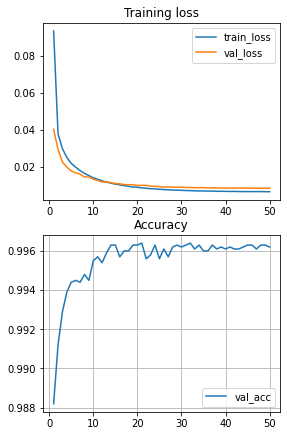

In [5]:
# if __name__=="__main__":
#     plot_log(ROOT+'/result_0522', '/log.csv') #, save=True)

# MNIST 56x56, 6000 images for training, 1000 images for testing

In [6]:
if __name__ == "__main__":
    
    # setting the hyper parameters
    parser2 = argparse.ArgumentParser(description="Capsule Network on MNIST 56x56.")
    
    parser2.add_argument('--epochs', default=70, type=int)
    parser2.add_argument('--batch_size', default=100, type=int)
    parser2.add_argument('--lr', default=0.0008, type=float,
                        help="Initial learning rate")
    parser2.add_argument('--lr_decay', default=0.96, type=float,
                        help="The value multiplied by lr at each epoch. Set a larger value for larger epochs")
    parser2.add_argument('--lam_recon', default=0.0005 * 784, type=float,
                        help="The coefficient for the loss of decoder")
    parser2.add_argument('-r', '--routings', default=3, type=int,
                        help="Number of iterations used in routing algorithm. should > 0")  # num_routing should > 0
    parser2.add_argument('--data_dir', default=ROOT+'/data_0522',
                        help="Directory of data. If no data, use \'--download\' flag to download it")
    parser2.add_argument('--download', action='store_true',
                        help="Download the required data.")
    parser2.add_argument('--save_dir', default=ROOT+'/result2_0522')
    parser2.add_argument('-t', '--testing', action='store_true',
                        help="Test the trained model on testing dataset")
    parser2.add_argument('-w', '--weights', default=ROOT+'/result2_0522' + '/trained_model56.pkl',
                        help="The path of the saved weights. Should be specified when testing")
    args2 = parser2.parse_args(args=['-t']) # '-t'
    print(args2)
    if not os.path.exists(args2.save_dir):
        os.makedirs(args2.save_dir)

    # load data
    train_loader56, test_loader56 = load_mnist(args2.data_dir, download=True, batch_size=args2.batch_size, input56=True)

    # define model
    model56 = CapsuleNet56(input_size=[1, 56, 56], classes=10, routings=3)
    model56.to(device)
    print(model56)

    # train or test
    if args2.weights is not None:  # init the model weights with provided one
        model56.load_state_dict(torch.load(args2.weights))
    if not args2.testing:
        train(model56, train_loader56, test_loader56, args2)
    else:  # testing
        if args2.weights is None:
            print('No weights are provided. Will test using random initialized weights.')
        test_loss56, test_acc56 = test(model=model56, test_loader=test_loader56, args=args2)
        print('test acc = %.4f, test loss = %.5f' % (test_acc56, test_loss56))


Namespace(batch_size=100, data_dir='/content/gdrive/My Drive/ECE4179_COLAB/Project2/data_0522', download=False, epochs=70, lam_recon=0.392, lr=0.0008, lr_decay=0.96, routings=3, save_dir='/content/gdrive/My Drive/ECE4179_COLAB/Project2/result2_0522', testing=True, weights='/content/gdrive/My Drive/ECE4179_COLAB/Project2/result2_0522/trained_model56.pkl')
CapsuleNet56(
  (conv1): Conv2d(1, 128, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(9, 9), stride=(2, 2))
  (primarycaps): PrimaryCapsule(
    (conv2d): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  )
  (digitcaps): DenseCapsule()
  (decoder): Sequential(
    (0): Linear(in_features=160, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=3136, bias=True)
    (5): Sigmoid()
  )
  (relu): ReLU()
)
test acc = 0.9885, test loss = 0.01573


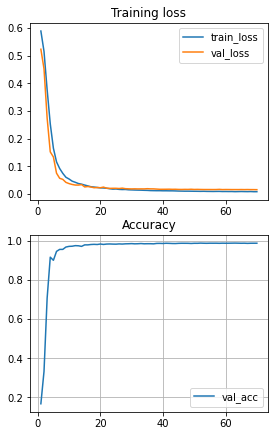

In [7]:
# if __name__=="__main__":
#     plot_log(ROOT+'/result2_0522', '/log.csv') #, save=True)

# baseline CNN, MNIST 28x28, 60000 images for training, 10000 images for testing

In [9]:
# Param
testing_cnn = True

num_epochs_cnn = 5
if testing_cnn:
    num_epochs_cnn = 1

num_classes_cnn = 10
batch_size_cnn = 100
learning_rate_cnn = 0.001

train_loader_cnn, test_loader_cnn = load_mnist(ROOT+'/data_0522', download=True, batch_size=batch_size_cnn)
model_cnn = ConvNet().to(device)

if testing_cnn:
    model_cnn.load_state_dict(torch.load(ROOT+'/result_cnn_0522/CNN.pkl'))

criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate_cnn)

In [10]:
#This cell implements our training loop
training_loss_logger_cnn = []
validation_loss_logger_cnn = []
train_acc_logger_cnn = []
valid_acc_logger_cnn = []

if testing_cnn:
    train_loss_cnn, train_acc_cnn = 0, 0

for epoch_cnn in range(num_epochs_cnn):
    
    if not testing_cnn:
        #call the training function and pass training dataloader etc
        train_loss_cnn, train_acc_cnn, train_acc_logger_cnn, training_loss_logger_cnn = train_cnn(model_cnn, device, train_loader_cnn, optimizer_cnn, criterion_cnn, train_acc_logger_cnn, training_loss_logger_cnn)
    
    #call the evaluate function and pass validation dataloader etc
    valid_loss_cnn, valid_acc_cnn, valid_acc_logger_cnn, validation_loss_logger_cnn = evaluate_cnn(model_cnn, device, test_loader_cnn, criterion_cnn, valid_acc_logger_cnn, validation_loss_logger_cnn)

    
    print(f'| Epoch: {epoch_cnn+1:02} | Train Loss: {train_loss_cnn:.3f} | Train Acc: {train_acc_cnn*100:05.2f}% | Val. Loss: {valid_loss_cnn:.3f} | Val. Acc: {valid_acc_cnn*100:05.2f}%')


EVALUATION: | Itteration [100/100] | Loss 0.02 | Accuracy 99.28% |
| Epoch: 01 | Train Loss: 0.000 | Train Acc: 00.00% | Val. Loss: 0.023 | Val. Acc: 99.28%


In [11]:
if not testing_cnn:
    torch.save(model_cnn.state_dict(), ROOT+'/result_cnn_0522/CNN.pkl')

# baseline CNN, MNIST 56x56, 6000 images for training, 1000 images for testing

In [12]:
# Param
testing_cnn56 = True
num_epochs_cnn56 = 28

if testing_cnn56:
    num_epochs_cnn56 = 1

num_classes_cnn56 = 10
batch_size_cnn56 = 100
learning_rate_cnn56 = 0.0005

train_loader_cnn56, test_loader_cnn56 = load_mnist(ROOT+'/data_0522', download=True, batch_size=batch_size_cnn56, input56=True)
model_cnn56 = ConvNet56().to(device)

if testing_cnn56:
    model_cnn56.load_state_dict(torch.load(ROOT+'/result_cnn_0522/CNN56.pkl'))

criterion_cnn56 = nn.CrossEntropyLoss()
optimizer_cnn56 = torch.optim.Adam(model_cnn56.parameters(), lr=learning_rate_cnn56)

In [ ]:
# fig = plt.figure()
# plt.imshow(next(iter(test_loader_cnn56))[0][0].squeeze(), cmap='gray')
# plt.savefig("MNIST56.png")

In [13]:
#This cell implements our training loop
training_loss_logger_cnn56 = []
validation_loss_logger_cnn56 = []
train_acc_logger_cnn56 = []
valid_acc_logger_cnn56 = []

if testing_cnn56:
    train_loss_cnn56, train_acc_cnn56 = 0, 0

for epoch_cnn56 in range(1):
    
    if not testing_cnn56:
        #call the training function and pass training dataloader etc
        train_loss_cnn56, train_acc_cnn56, train_acc_logger_cnn56, training_loss_logger_cnn56 = train_cnn(model_cnn56, device, train_loader_cnn56, optimizer_cnn56, criterion_cnn56, train_acc_logger_cnn56, training_loss_logger_cnn56)
    
    #call the evaluate function and pass validation dataloader etc
    valid_loss_cnn56, valid_acc_cnn56, valid_acc_logger_cnn56, validation_loss_logger_cnn56 = evaluate_cnn(model_cnn56, device, test_loader_cnn56, criterion_cnn56, valid_acc_logger_cnn56, validation_loss_logger_cnn56)

    
    print(f'| Epoch: {epoch_cnn56+1:02} | Train Loss: {train_loss_cnn56:.3f} | Train Acc: {train_acc_cnn56*100:05.2f}% | Val. Loss: {valid_loss_cnn56:.3f} | Val. Acc: {valid_acc_cnn56*100:05.2f}%')


EVALUATION: | Itteration [100/100] | Loss 0.06 | Accuracy 97.64% |
| Epoch: 01 | Train Loss: 0.000 | Train Acc: 00.00% | Val. Loss: 0.080 | Val. Acc: 97.64%


In [14]:
if not testing_cnn56:
    torch.save(model_cnn56.state_dict(), ROOT+'/result_cnn_0522/CNN56.pkl')

# test affine transformed

In [16]:
_, test_loader_aff = load_mnist(args2.data_dir, download=True, batch_size=args2.batch_size, aff_test=True)

In [17]:
val_loss_aff, val_acc_aff = test(model56, test_loader_aff, args2)
print(val_acc_aff)

tensor(0.8935)


In [18]:
criterion_cnn56_aff = nn.CrossEntropyLoss()
validation_loss_logger_cnn56_aff = []
valid_acc_logger_cnn56_aff = []
_, valid_acc_cnn56_aff, _, _ = evaluate_cnn(model_cnn56, device, test_loader_aff, criterion_cnn56_aff, valid_acc_logger_cnn56_aff, validation_loss_logger_cnn56_aff)

EVALUATION: | Itteration [100/100] | Loss 0.68 | Accuracy 82.82% |


In [ ]:
# plt.imshow(next(iter(test_loader_aff))[0][0].squeeze(), cmap='gray')

# test 2-digit MNIST

In [19]:
_, test_loader_multi = load_mnist(args2.data_dir, download=True, batch_size=args2.batch_size, multi_test=True)

In [20]:
model56.eval()
test_loss_multi = 0
correct_multi = 0
valid_pair = 0
with torch.no_grad():
  for x, y in test_loader_multi:

      x_multi_top = torch.cat((x[:50], torch.zeros((x[:50].shape))), dim=3)
      x_multi_bottom = torch.cat((torch.zeros((x[50:].shape)), x[50:]), dim=3)
      x_multi = torch.cat((x_multi_top, x_multi_bottom), dim=2)
      
      y = torch.zeros(y.size(0), 10).scatter_(1, y.view(-1, 1), 1.)

      y_multi = y[:50] + y[50:]

      x_multi = x_multi[y_multi.max(1)[0] < 1.5]
      y_multi = y_multi[y_multi.max(1)[0] < 1.5]

      x_multi, y_multi = Variable(x_multi.to(device)), Variable(y_multi.to(device))
      y_pred_multi, _ = model56(x_multi)
      
      y_pred = y_pred_multi.data.topk(2)[1].sort()[0]
      y_true = y_multi.data.topk(2)[1].sort()[0]
      y_pred_onehot = torch.zeros(y_pred.cpu().size(0), 10).scatter_(1, y_pred.cpu().view(-1, 2), 1.)
      y_true_onehot = torch.zeros(y_true.cpu().size(0), 10).scatter_(1, y_true.cpu().view(-1, 2), 1.)
      
      correct_multi += y_pred_onehot[y_pred_onehot==1].eq(y_true_onehot[y_pred_onehot==1]).cpu().sum()
      valid_pair += y_pred.numel()

test_acc = correct_multi / valid_pair
print(test_acc)

tensor(0.9718)


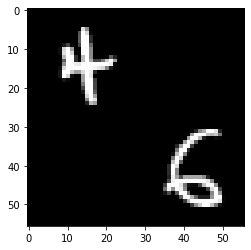

In [34]:
# plt.imshow(x_multi[0][0].cpu().squeeze(), cmap='gray')

In [21]:
model_cnn56.eval()
test_loss_multi_cnn56 = 0
correct_multi_cnn56 = 0
valid_pair_cnn56= 0
with torch.no_grad():
  for x_cnn56, y_cnn56 in test_loader_multi:

      x_multi_top_cnn56 = torch.cat((x_cnn56[:50], torch.zeros((x_cnn56[:50].shape))), dim=3)
      x_multi_bottom_cnn56 = torch.cat((torch.zeros((x_cnn56[50:].shape)), x_cnn56[50:]), dim=3)
      x_multi_cnn56 = torch.cat((x_multi_top_cnn56, x_multi_bottom_cnn56), dim=2)
      
      y_cnn56 = torch.zeros(y_cnn56.size(0), 10).scatter_(1, y_cnn56.view(-1, 1), 1.)

      y_multi_cnn56 = y_cnn56[:50] + y_cnn56[50:]

      x_multi_cnn56 = x_multi_cnn56[y_multi_cnn56.max(1)[0] < 1.5]
      y_multi_cnn56 = y_multi_cnn56[y_multi_cnn56.max(1)[0] < 1.5]
      
      x_multi_cnn56, y_multi_cnn56 = Variable(x_multi_cnn56.to(device)), Variable(y_multi_cnn56.to(device))
      y_pred_multi_cnn56 = model_cnn56(x_multi_cnn56)

      y_pred_cnn56 = y_pred_multi_cnn56.data.topk(2)[1].sort()[0]
      y_true_cnn56 = y_multi_cnn56.data.topk(2)[1].sort()[0]
      y_pred_onehot_cnn56 = torch.zeros(y_pred_cnn56.cpu().size(0), 10).scatter_(1, y_pred_cnn56.cpu().view(-1, 2), 1.)
      y_true_onehot_cnn56 = torch.zeros(y_true_cnn56.cpu().size(0), 10).scatter_(1, y_true_cnn56.cpu().view(-1, 2), 1.)
      
      correct_multi_cnn56 += y_pred_onehot_cnn56[y_pred_onehot_cnn56==1].eq(y_true_onehot_cnn56[y_pred_onehot_cnn56==1]).cpu().sum()
      valid_pair_cnn56 += y_pred_cnn56.numel()

test_acc_cnn56 = correct_multi_cnn56 / valid_pair_cnn56
print(test_acc_cnn56)

tensor(0.5441)


In [22]:
print('Model\n')
print(summary(model, input_size=(1, 28, 28)))
print('Model56\n')
print(summary(model56, input_size=(1, 56, 56)))
print('Model_cnn\n')
print(summary(model_cnn, input_size=(1, 28, 28)))
print('Model_cnn56\n')
print(summary(model_cnn56, input_size=(1, 56, 56)))

Model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 20, 20]          20,992
              ReLU-2          [-1, 256, 20, 20]               0
            Conv2d-3            [-1, 256, 6, 6]       5,308,672
    PrimaryCapsule-4              [-1, 1152, 8]               0
      DenseCapsule-5               [-1, 10, 16]       1,474,560
            Linear-6                  [-1, 512]          82,432
              ReLU-7                  [-1, 512]               0
            Linear-8                 [-1, 1024]         525,312
              ReLU-9                 [-1, 1024]               0
           Linear-10                  [-1, 784]         803,600
          Sigmoid-11                  [-1, 784]               0
Total params: 8,215,568
Trainable params: 8,215,568
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.